In [80]:
import glob

import pandas as pd
import pydicom
import matplotlib.pyplot as plt
import glob

In [81]:
data = pd.read_csv("../data/rsna-2024-lumbar-spine-degenerative-classification/train_label_coordinates.csv")

In [82]:
data

,study_id,series_id,instance_number,condition,level,x,y
0,4003253,702807833,8,Spinal Canal Stenosis,L1/L2,322.831858,227.964602
1,4003253,702807833,8,Spinal Canal Stenosis,L2/L3,320.571429,295.714286
2,4003253,702807833,8,Spinal Canal Stenosis,L3/L4,323.030303,371.818182
3,4003253,702807833,8,Spinal Canal Stenosis,L4/L5,335.292035,427.327434
4,4003253,702807833,8,Spinal Canal Stenosis,L5/S1,353.415929,483.964602
...,...,...,...,...,...,...,...
48687,4290709089,4237840455,11,Left Neural Foraminal Narrowing,L1/L2,219.465940,97.831063
48688,4290709089,4237840455,12,Left Neural Foraminal Narrowing,L2/L3,205.340599,140.207084
48689,4290709089,4237840455,12,Left Neural Foraminal Narrowing,L3/L4,202.724796,181.013624
48690,4290709089,4237840455,12,Left Neural Foraminal Narrowing,L4/L5,202.933333,219.733333


In [83]:
# Per study:
# 1- Map coords for sagittal (x, y)
# 2- Map coords for axial (y, z)
# 3 Extrapolate the y for axial and z for sagittal from the slice metadata
# 4 Add a buffer 20 px from min and max for each, aggregated per joint

In [84]:
base_path = "../data/rsna-2024-lumbar-spine-degenerative-classification/"
study = 4003253
series = 702807833  #T2STIR for canal stenosis
instance = 9
file = glob.glob(f"{base_path}/train_images/{study}/{series}/*{instance}.dcm")[0]

data_slice = pydicom.dcmread(file)
data_slice

Dataset.file_meta -------------------------------
(0002, 0001) File Meta Information Version       OB: b'\x00\x01'
(0002, 0002) Media Storage SOP Class UID         UI: Enhanced MR Image Storage
(0002, 0003) Media Storage SOP Instance UID      UI: 4003253.1.9
(0002, 0010) Transfer Syntax UID                 UI: RLE Lossless
(0002, 0012) Implementation Class UID            UI: 1.2.40.0.13.1.1.1
(0002, 0013) Implementation Version Name         SH: 'PYDICOM 2.4.2'
-------------------------------------------------
(0008, 0018) SOP Instance UID                    UI: 4003253.1.9
(0008, 0023) Content Date                        DA: '20240503'
(0008, 0033) Content Time                        TM: '223713.422388'
(0008, 103e) Series Description                  LO: 'T2'
(0010, 0020) Patient ID                          LO: '4003253'
(0018, 0050) Slice Thickness                     DS: '4.0'
(0018, 0088) Spacing Between Slices              DS: '4.8'
(0018, 5100) Patient Position                   

In [85]:
#plt.imshow(data_slice.pixel_array)

In [86]:
import torch


# !TODO: Move to util func
def show_mid_slices(img4d):
    if torch.is_tensor(img4d):
        try:
            img4d = img4d.detach().cpu().numpy()
        except Exception as e:
            pass

    for i in range(len(img4d)):
        img3d = img4d[i]
        img_shape = img3d.shape

        a1 = plt.subplot(3, 3, i * 3 + 1)
        a1.imshow(img3d[:, :, img_shape[2] // 2], cmap="hot")
        a1.grid(None)

        a2 = plt.subplot(3, 3, i * 3 + 2)
        a2.imshow(img3d[:, img_shape[1] // 2, :], cmap="hot")
        a2.grid(None)

        a3 = plt.subplot(3, 3, i * 3 + 3)
        a3.imshow(img3d[img_shape[0] // 2, :, :].T, cmap="hot")
        a3.grid(None)

    plt.show()

In [87]:
data_for_series = data[(data["study_id"] == study) & (data["series_id"] == series)]

In [88]:
from rsna_dataloader import *

series_volume = read_series_as_volume(f"{base_path}/train_images/{study}/{series}/")

In [89]:
def get_sagittal_bounding_boxes(series_data):
    sagittal_coords = []
    slice_instances = series_data["instance_number"].unique()

    for i in slice_instances:
        subset = series_data[series_data["instance_number"] == i].sort_values(by="level")
        for index, row in subset.iterrows():
            sagittal_coords.append([row["level"], i, row["y"], row["x"]])

    sagittal_coords = pd.DataFrame(sagittal_coords, columns=("level", "x", "y", "z"))
    sagittal_coords_groups = sagittal_coords.groupby("level").agg(("min", "max"))

    # !TODO: Buffer sizes for slices. 1/3 or 1/4 overall maybe
    sagittal_coords_groups["x_s"] = sagittal_coords_groups[("x", "min")].values - 2
    sagittal_coords_groups["x_e"] = sagittal_coords_groups[("x", "max")].values + 2
    sagittal_coords_groups["y_s"] = sagittal_coords_groups[("y", "min")].values - 20
    sagittal_coords_groups["y_e"] = sagittal_coords_groups[("y", "max")].values + 20
    sagittal_coords_groups["z_s"] = sagittal_coords_groups[("z", "min")].values - 20
    sagittal_coords_groups["z_e"] = sagittal_coords_groups[("z", "max")].values + 20

    return sagittal_coords_groups[["x_s", "x_e", "y_s", "y_e", "z_s", "z_e"]]

In [90]:
get_sagittal_bounding_boxes(data_for_series)

,x_s,x_e,y_s,y_e,z_s,z_e
,,,,,,
level,,,,,,
L1/L2,6,10,207.964602,247.964602,302.831858,342.831858
L2/L3,6,10,275.714286,315.714286,300.571429,340.571429
L3/L4,6,10,351.818182,391.818182,303.030303,343.030303
L4/L5,6,10,407.327434,447.327434,315.292035,355.292035
L5/S1,6,10,463.964602,503.964602,333.415929,373.415929


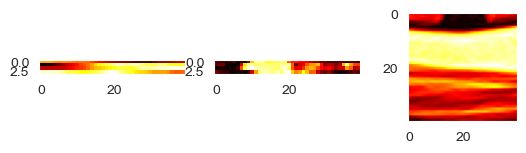

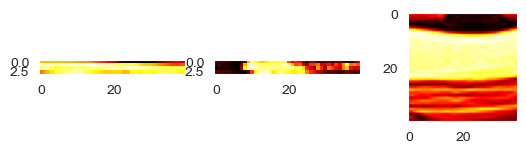

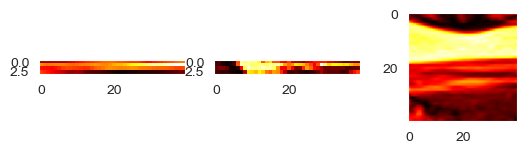

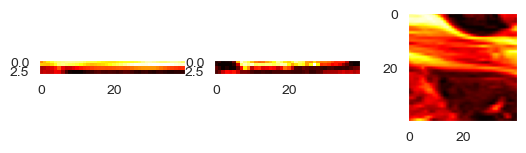

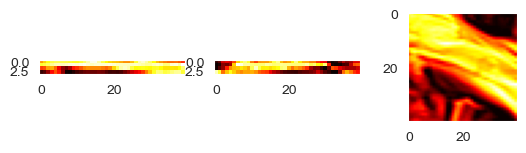

In [91]:
bounding_boxes = get_sagittal_bounding_boxes(data_for_series)

for level in ["L1/L2", "L2/L3", "L3/L4", "L4/L5", "L5/S1"]:
    box = bounding_boxes.loc[level]
    x_s, x_e, y_s, y_e, z_s, z_e = box.values.astype(int)

    show_mid_slices(np.expand_dims(series_volume[x_s:x_e, y_s:y_e, z_s:z_e], 0))

In [92]:
series = 1054713880  # T1 for foraminal narrowing
instance = 4

file = glob.glob(f"{base_path}/train_images/{study}/{series}/*{instance}.dcm")[0]

data_for_series = data[(data["study_id"] == study) & (data["series_id"] == series)]

In [93]:
# 5. Volume cube detection will be on low definition volumes
# 6. And the diagnosis inference will be based on the full res using the coordinates extracted previously

In [94]:
from rsna_dataloader import *

series_volume = read_series_as_volume(f"{base_path}/train_images/{study}/{series}/")

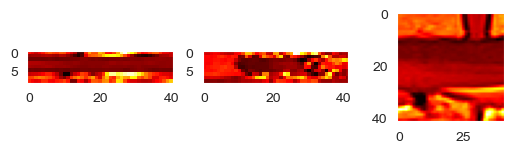

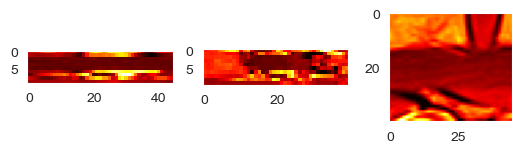

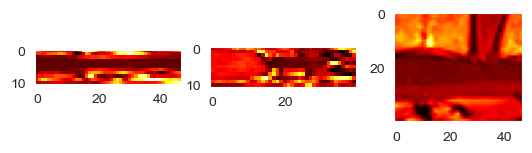

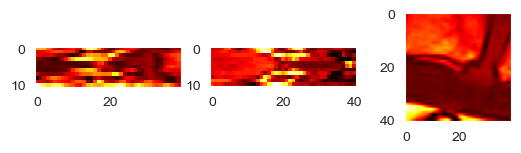

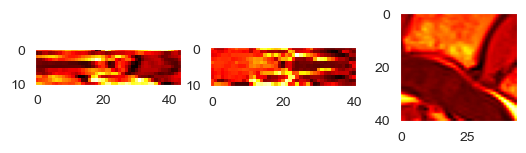

In [95]:
bounding_boxes = get_sagittal_bounding_boxes(data_for_series)

for level in ["L1/L2", "L2/L3", "L3/L4", "L4/L5", "L5/S1"]:
    box = bounding_boxes.loc[level]
    x_s, x_e, y_s, y_e, z_s, z_e = box.values.astype(int)

    show_mid_slices(np.expand_dims(series_volume[x_s:x_e, y_s:y_e, z_s:z_e], 0))